## Import libraries

In [2]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import cv2
import pickle
import scipy

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

ModuleNotFoundError: No module named 'cv2'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Colab\ Notebooks/Speech\ Emotion\ Recognition/Implementations/5_Conv_1D

/content/drive/MyDrive/Colab Notebooks/Speech Emotion Recognition/Implementations/5_Conv_1D


## Get data from datasets:

In [ ]:
main_path = 'D://emotion_recognition_data'
TESS = "tess/TESS Toronto emotional speech set data/"
RAV = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "savee/ALL/"

dir_list = os.listdir(SAVEE)
dir_list[0:5]

['DC_a01.wav', 'DC_a02.wav', 'DC_a13.wav', 'DC_a12.wav', 'DC_a06.wav']

### RAVDESS dataset

In [ ]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[19:20])
            
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

In [ ]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])


In [ ]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [ ]:
df.head()

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,calm,speech,audio only,strong,male,Dogs are sitting by the door,ravdess-emotional-speech-audio/audio_speech_ac...
1,angry,speech,audio only,normal,male,Dogs are sitting by the door,ravdess-emotional-speech-audio/audio_speech_ac...
2,happy,speech,audio only,strong,male,Dogs are sitting by the door,ravdess-emotional-speech-audio/audio_speech_ac...
3,sad,speech,audio only,normal,male,Kids are talking by the door,ravdess-emotional-speech-audio/audio_speech_ac...
4,angry,speech,audio only,normal,male,Kids are talking by the door,ravdess-emotional-speech-audio/audio_speech_ac...


### SAVEE

In [ ]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry_male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust_male')
    elif i[-8:-6]=='_f':
        emotion.append('fear_male')
    elif i[-8:-6]=='_h':
        emotion.append('happy_male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral_male')
    elif i[-8:-6]=='sa':
        emotion.append('sad_male')
    elif i[-8:-6]=='su':
        emotion.append('surprise_male')
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral_male     120
happy_male        60
sad_male          60
disgust_male      60
angry_male        60
surprise_male     60
fear_male         60
Name: emotion_label, dtype: int64

In [ ]:
SAVEE_df.head()

,emotion_label,source,path
0,angry_male,SAVEE,savee/ALL/DC_a01.wav
1,angry_male,SAVEE,savee/ALL/DC_a02.wav
2,angry_male,SAVEE,savee/ALL/DC_a13.wav
3,angry_male,SAVEE,savee/ALL/DC_a12.wav
4,angry_male,SAVEE,savee/ALL/DC_a06.wav


### TESS dataset

In [1]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry_female')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust_female')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear_female')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy_female')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral_female')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise_female')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad_female')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

NameError: name 'os' is not defined

In [ ]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [ ]:
TESS_df.head()

,emotion_label,source,path
0,fear_female,TESS,tess/TESS Toronto emotional speech set data/OA...
1,fear_female,TESS,tess/TESS Toronto emotional speech set data/OA...
2,fear_female,TESS,tess/TESS Toronto emotional speech set data/OA...
3,fear_female,TESS,tess/TESS Toronto emotional speech set data/OA...
4,fear_female,TESS,tess/TESS Toronto emotional speech set data/OA...


### Combining the datasets:

In [ ]:
RAV_df = df.copy()

# only speech
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

RAV_df.insert(0, "emotion_label", RAV_df.emotion+'_'+RAV_df.actors, True)
RAV_df.insert(1, "source", "RAV", True)
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)
RAV_df.head()

,emotion_label,source,actors,path
0,calm_male,RAV,male,ravdess-emotional-speech-audio/audio_speech_ac...
1,angry_male,RAV,male,ravdess-emotional-speech-audio/audio_speech_ac...
2,happy_male,RAV,male,ravdess-emotional-speech-audio/audio_speech_ac...
3,sad_male,RAV,male,ravdess-emotional-speech-audio/audio_speech_ac...
4,angry_male,RAV,male,ravdess-emotional-speech-audio/audio_speech_ac...


In [ ]:
TESS_df.insert(2, "actors", "female", True)
SAVEE_df.insert(2, "actors", "male", True)

In [ ]:
SAVEE_df['emotion_label'].unique()

array(['angry_male', 'disgust_male', 'happy_male', 'fear_male',
       'neutral_male', 'sad_male', 'surprise_male'], dtype=object)

In [ ]:
df_combined = pd.concat([TESS_df, RAV_df, SAVEE_df])
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4720 entries, 0 to 479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion_label  4720 non-null   object
 1   source         4720 non-null   object
 2   actors         4720 non-null   object
 3   path           4720 non-null   object
dtypes: object(4)
memory usage: 184.4+ KB


In [ ]:
for col in ['emotion_label', 'source', 'actors']:
    print('\nColumn values for ', col.upper())
    print(df_combined[col].value_counts())


Column values for  EMOTION_LABEL
angry_female        496
happy_female        496
disgust_female      496
sad_female          496
neutral_female      448
fear_female         400
surprise_female     400
neutral_male        168
disgust_male        156
sad_male            156
happy_male          156
angry_male          156
calm_female          96
fearful_female       96
fearful_male         96
calm_male            96
surprised_male       96
surprised_female     96
surprise_male        60
fear_male            60
Name: emotion_label, dtype: int64

Column values for  SOURCE
TESS     2800
RAV      1440
SAVEE     480
Name: source, dtype: int64

Column values for  ACTORS
female    3520
male      1200
Name: actors, dtype: int64


In [ ]:
new_labels_dict_comb = {'angry_male':'negative_male', 'angry_female':'negative_female', 
                        'calm_male':'neutral_male', 'calm_female':'neutral_female',
                        'disgust_male':'negative_male', 'disgust_female':'negative_female', 
                        'fearful_male':'negative_male','fearful_female':'negative_female',
                        'fear_male':'negative_male', 'fear_female':'negative_female',
                        'happy_male':'positive_male', 'happy_female':'positive_female',
                        'neutral_male':'neutral_male', 'neutral_female':'neutral_female',
                        'sad_male':'negative_male', 'sad_female':'negative_female',
                        'surprised_male':'positive_male', 'surprised_female':'positive_female',
                        'surprise_male':'positive_male', 'surprise_female':'positive_female',
                        'Unknown': 'unk'}

df_combined['emotion2'] = df_combined['emotion_label'].map(new_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2
0,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female
1,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female
2,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female
3,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female
4,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female


In [ ]:
addit_labels_dict_comb = {'angry_male':'angry', 'angry_female':'angry', 
                        'calm_male':'neutral', 'calm_female':'neutral',
                        'disgust_male':'negative', 'disgust_female':'negative', 
                        'fearful_male':'fear','fearful_female':'fear',
                        'fear_male':'fear', 'fear_female':'fear',
                        'happy_male':'positive', 'happy_female':'positive',
                        'neutral_male':'neutral', 'neutral_female':'neutral',
                        'sad_male':'sadness', 'sad_female':'sadness',
                        'surprised_male':'surprise', 'surprised_female':'surprise',
                        'surprise_male':'surprise', 'surprise_female':'surprise',
                        'Unknown': 'unk'}

df_combined['emotion3'] = df_combined['emotion_label'].map(addit_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
1,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
2,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
3,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
4,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear


In [ ]:
df_combined.emotion2.value_counts()

negative_female    1984
positive_female     992
negative_male       624
neutral_female      544
positive_male       312
neutral_male        264
Name: emotion2, dtype: int64

In [ ]:
df_combined.emotion3.value_counts()

neutral     808
fear        652
sadness     652
surprise    652
angry       652
positive    652
negative    652
Name: emotion3, dtype: int64

In [ ]:
df_combined = df_combined.loc[df_combined['emotion2'] != 'unk']

### Save the data:

In [ ]:
pip install fsspec

     |████████████████████████████████| 118 kB 29.0 MB/s eta 0:00:01


In [ ]:
df_combined.to_csv(os.path.join(main_path,"combined.csv"), index=False)

### (Using the combined DF, MFCC's and column 'emotion2' as target)

In [ ]:
%ls

 autoencoder.hdf5
 Autoencoder.ipynb
 binary.hdf5
 binary_scaled_augmented_CHANGE_ORDER.hdf5
 binary_scaled_augmented.hdf5
 binary_scaled.hdf5
 Conv1D_Binary.ipynb
 Conv1D_multiclass.ipynb
 D:/
 emodb/
 mfccs2.pickle
 mfccs2_without_replications.pickle
 mfccs_aug.pickle
 mfccs_aug_without_replicates.pickle
 mfccs_aug_without_replicates_pn_CHANGE_ORDER.pickle
 mfccs_aug_without_replicates_pn.pickle
 mfccs.pickle
 model3.h5
 multiclass_model_scaled/
 multiclass_model_scaled_without_replications/
 multiclass_model_scaled_without_replications_augmented/
 multiclass_model_scaled_without_replications_augmented_pn/
 multiclass_model_scaled_without_replications_augmented_pn_CHANGE_ORDER/
 multiclass_scaled.hdf5
 multiclass_scaled_without_replication_augmented.hdf5
 multiclass_scaled_without_replication_augmented_pn_CHANGE_ORDER.hdf5
 multiclass_scaled_without_replication_augmented_pn.hdf5
 multiclass_scaled_without_replication.hdf5
 my_model/
 my_model_binary/
 my_model_binary_scaled/
 my_mode

In [ ]:
import pickle

df_path = 'combined.csv'
# mfccs_path = 'd://itc//final_project//mfccs.pickle'
# new_y_path = 'd://itc//final_project//y.pickle'

# with open('d://downloads//y.pickle', 'wb') as f:
#     pickle.dump(new_y, f)
    
# with open('d://downloads//mfccs.pickle', 'wb') as f:
#     pickle.dump(mfccs, f)

mydf = pd.read_csv(df_path)

# with open(mfccs_path, 'rb') as f:
#     mfccs = pickle.load(f)

# with open(new_y_path, 'rb') as f:
#     new_y = pickle.load(f)

FileNotFoundError: ignored

# Conv Model

## Feature Extraction

### Normal

In [ ]:
mydf['emotion3'].unique()

array(['fear', 'surprise', 'sadness', 'angry', 'negative', 'positive',
       'neutral'], dtype=object)

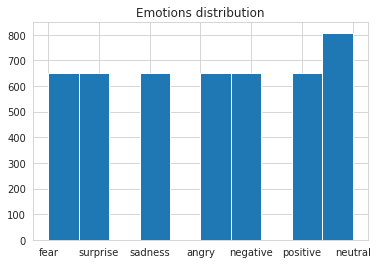

In [ ]:
plt.title('Emotions distribution')
plt.hist(mydf['emotion3'])
# plt.hist(y)
plt.show()

In [ ]:
y = mydf['emotion3'].copy()

In [ ]:
mydf.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
1,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
2,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
3,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
4,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear


In [ ]:
y.shape

(4720,)

In [ ]:
X = []
for i in tqdm(mydf['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
lengths = [len(x) for x in new_x]

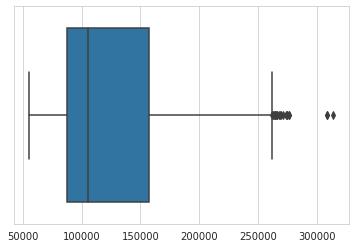

In [ ]:
sns.boxplot(lengths)
plt.show()

3


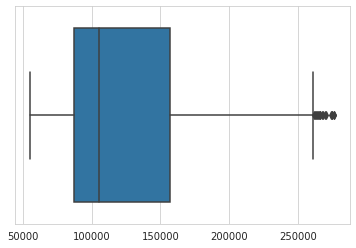

In [ ]:
# outliers
lengths = np.array(lengths)
print((lengths > 300000).sum())
new_lengths = lengths[lengths < 300000]

sns.boxplot(new_lengths)
plt.show()

In [ ]:
print(new_lengths.mean())

120378.67500529999


In [ ]:
length_chosen = 120378
#length_chosen = 117841

In [ ]:
y = y.reset_index(drop = True)
#new_x = new_x.reset_index(drop = True)

In [ ]:
import math

X_new = []
y_new = []
count = 0 
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        print(y[count])
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

(4717,) (4717,)


In [ ]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

(4717, 236, 40)

In [ ]:
set(y)

{'angry', 'fear', 'negative', 'neutral', 'positive', 'sadness', 'surprise'}

#### Save new data

In [ ]:
import pickle 

mfccs2_path = 'mfccs2_without_replications.pickle'
y2_path = 'y2_without_replications.pickle'


with open(mfccs2_path, 'wb') as f:
     pickle.dump(mfccs,f)
    
with open(y2_path, 'wb') as f:
     pickle.dump(y,f)
  


#### Load data

In [ ]:
with open(mfccs2_path, 'rb') as f:
    mfccs = pickle.load(f)
    
with open(y2_path, 'rb') as f:
    y = pickle.load(f)

### Data Augmentation, Weiner, Trim

In [ ]:
mydf = df_combined

In [ ]:
mydf['emotion3'].unique()

array(['fear', 'surprise', 'sadness', 'angry', 'negative', 'positive',
       'neutral'], dtype=object)

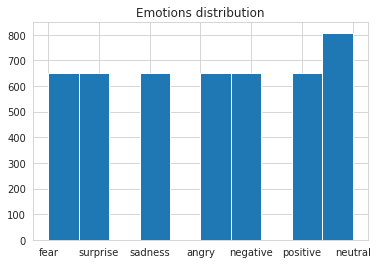

In [ ]:
plt.title('Emotions distribution')
plt.hist(mydf['emotion3'])
# plt.hist(y)
plt.show()

In [ ]:
y = mydf['emotion3'].copy()

In [ ]:
mydf.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
1,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
2,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
3,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear
4,fear_female,TESS,female,tess/TESS Toronto emotional speech set data/OA...,negative_female,fear


In [ ]:
y.shape

(4720,)

In [ ]:
X = []
for i in tqdm(mydf['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
lengths = [len(x) for x in new_x]

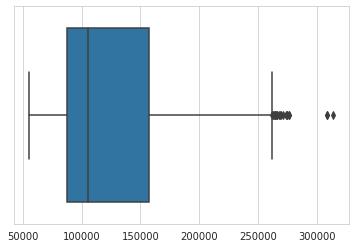

In [ ]:
sns.boxplot(lengths)
plt.show()

3


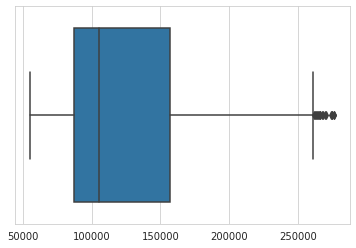

In [ ]:
# outliers
lengths = np.array(lengths)
print((lengths > 300000).sum())
new_lengths = lengths[lengths < 300000]

sns.boxplot(new_lengths)
plt.show()

In [ ]:
print(new_lengths.mean())

120378.67500529999


In [ ]:
length_chosen = 120378
#length_chosen = 117841

In [ ]:
y = y.reset_index(drop = True)
#new_x = new_x.reset_index(drop = True)

In [ ]:
import math

X_new = []
y_new = []
count = 0 
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        print(y[count])
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

(4717,) (4717,)


In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
mfccs = []
counter = 0 
for i in tqdm(X):

   # Weiner Filtering on original noise 
    samples_weiner = scipy.signal.wiener(i)
    is_fin = np.isfinite(samples_weiner).all()


    # Data Augmentation - Noise 
    noise_audio = noise(samples_weiner)

    # Data Augmentation - Pitch 
    pitch_audio = pitch(samples_weiner, sampling_rate=44000)


    # Data Augmentation -  pitch + noise 
    pn = pitch(samples_weiner, sampling_rate = 44000)




    if is_fin: 
      # MFCC

      mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
      mfcc = mfcc.T
      mfccs.append(mfcc)

      mfcc_augmented = librosa.feature.mfcc(y=samples_weiner, sr=44000, n_mfcc=40)
      mfcc_augmented = mfcc_augmented.T
      mfccs.append(mfcc_augmented)

      mfcc_augmented_pitch = librosa.feature.mfcc(y=noise_audio, sr=44000, n_mfcc=40)
      mfcc_augmented_pitch = mfcc_augmented_pitch.T
      mfccs.append(mfcc_augmented_pitch)

      mfcc_augmented_p = librosa.feature.mfcc(y=pitch_audio, sr=44000, n_mfcc=40)
      mfcc_augmented_p = mfcc_augmented_p.T
      mfccs.append(mfcc_augmented_p) 

      mfcc_augmented_pn = librosa.feature.mfcc(y=pn, sr=44000, n_mfcc=40)
      mfcc_augmented_pn = mfcc_augmented_pn.T
      mfccs.append(mfcc_augmented_pn) 
                                                                         



In [ ]:
len(y)

9434

In [ ]:
# duplicate y in same way of X 
y_prov = []
for i in range(len(y)): 
  y_prov.append(y[i])
  y_prov.append(y[i])
  y_prov.append(y[i])
  y_prov.append(y[i])
  y_prov.append(y[i])
y = np.asarray(y_prov)

In [ ]:
# controllare che ora gli mfcc siano il doppio
len(mfccs)

23585

In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

(23585, 236, 40)

In [ ]:
y.shape

(23585,)

In [ ]:
set(y)

{'angry', 'fear', 'negative', 'neutral', 'positive', 'sadness', 'surprise'}

#### Save new data

In [ ]:
import pickle 

mfccsaug_path = 'mfccs_aug_without_replicates_pn_CHANGE_ORDER.pickle'
yaug_path = 'y_aug_without_replicates_pn_CHANGE_ORDER.pickle'

'''
with open(mfccsaug_path, 'wb') as f:
     pickle.dump(mfccs,f)
    
with open(yaug_path, 'wb') as f:
     pickle.dump(y,f)
'''

"\nwith open(mfccsaug_path, 'wb') as f:\n     pickle.dump(mfccs,f)\n    \nwith open(yaug_path, 'wb') as f:\n     pickle.dump(y,f)\n"

#### Load data

In [ ]:
with open(mfccsaug_path, 'rb') as f:
    mfccs = pickle.load(f)
    
with open(yaug_path, 'rb') as f:
    y = pickle.load(f)

## Save new data

In [ ]:
import pickle 

mfccs2_path = 'mfccs2.pickle'
y2_path = 'y2.pickle'

'''
with open(mfccs2_path, 'wb') as f:
     pickle.dump(mfccs,f)
    
with open(y2_path, 'wb') as f:
     pickle.dump(y,f)
'''   


"\nwith open(mfccs2_path, 'wb') as f:\n     pickle.dump(mfccs,f)\n    \nwith open(y2_path, 'wb') as f:\n     pickle.dump(y,f)\n"

## Load data

In [ ]:
with open(mfccs2_path, 'rb') as f:
    mfccs = pickle.load(f)
    
with open(y2_path, 'rb') as f:
    y = pickle.load(f)

## Encode labels

In [ ]:
set(y)

{'angry', 'fear', 'negative', 'neutral', 'positive', 'sadness', 'surprise'}

In [ ]:
y = np.where(y=='positive', 'happy', y)
y = np.where(y=='negative', 'disgust', y)

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

## Train Test Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(mfccs, y, test_size=0.2, random_state=12) #12
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=15) #15

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((18868, 236, 40),
 (2358, 236, 40),
 (2359, 236, 40),
 (18868,),
 (2358,),
 (2359,))

In [ ]:
y_train = pd.Series(y_train).map(emotion_enc)
y_val = pd.Series(y_val).map(emotion_enc)
y_test = pd.Series(y_test).map(emotion_enc)

In [ ]:
y_train.unique(), y_test.unique(), y_val.unique()

(array([0, 1]), array([1, 0]), array([0, 1]))

## Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

## Save Scaler fitted

In [ ]:
with open('scaler', 'wb') as f:
     pickle.dump(scaler,f)

## Model

In [ ]:
model3 = Sequential()

model3.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(236,40)))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(8)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv1D(128, 5,padding='same'))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(4)))
model3.add(layers.Dropout(0.1))

model3.add(layers.Flatten())
model3.add(layers.Dense(64))
model3.add(layers.Dense(1))
model3.add(layers.Activation('sigmoid'))

model3.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 236, 256)          51456     
_________________________________________________________________
activation (Activation)      (None, 236, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 29, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0

## Training

In [ ]:
# weight_path2 = 'd://ITC//final_project_data//best_weights3.hdf5'
weight_path2 = 'binary_scaled_augmented_CHANGE_ORDER.hdf5'

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path2, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model3.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint2], class_weight = class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
1180/1180 [==============================] - 53s 44ms/step - loss: 0.2852 - accuracy: 0.8532 - val_loss: 0.1833 - val_accuracy: 0.9097
Epoch 2/500
1180/1180 [==============================] - 52s 44ms/step - loss: 0.1850 - accuracy: 0.9121 - val_loss: 0.1347 - val_accuracy: 0.9364
Epoch 3/500
1180/1180 [==============================] - 52s 44ms/step - loss: 0.1408 - accuracy: 0.9370 - val_loss: 0.1090 - val_accuracy: 0.9500
Epoch 4/500
1180/1180 [==============================] - 52s 44ms/step - loss: 0.1109 - accuracy: 0.9525 - val_loss: 0.0842 - val_accuracy: 0.9631
Epoch 5/500
1180/1180 [==============================] - 52s 44ms/step - loss: 0.0866 - accuracy: 0.9645 - val_loss: 0.0761 - val_accuracy: 0.9652
Epoch 6/500
1180/1180 [==============================] - 52s 44ms/step - loss: 0.0731 - accuracy: 0.9722 - val_loss: 0.0831 - v

## Save model

In [ ]:
model3.save("my_model_binary_scaled_pn_CHANGE_ORDER")

INFO:tensorflow:Assets written to: my_model_binary_scaled_pn_CHANGE_ORDER/assets


In [ ]:
model3.evaluate(X_test, y_test, batch_size=16)

56/56 [==============================] - 1s 18ms/step - loss: 0.2437 - accuracy: 0.9420


[0.24373212456703186, 0.9419642686843872]

In [ ]:
predictions = model3.predict(X_test)

In [ ]:
pred = [1 * (x[0]>=0.5) for x in predictions]

In [ ]:
counter = 0 
for i in range(len(pred)):
  if predictions[i] != y_test[i]:
    counter +=1
counter 


491

In [ ]:
len(y_test)

896

## Final evaluation

In [ ]:
def report_res_and_plot_matrix(y_test, y_pred, plot_classes):

  #report metrics
  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {acc:.4f}")
  # print(f"Classes: {plot_classes}")

  #plot matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
    
  tick_marks = np.arange(len(plot_classes))
  plt.xticks(ticks=tick_marks, labels=plot_classes, rotation=90)
  plt.yticks(ticks=tick_marks, labels=plot_classes, rotation=90)

  group_counts = [f'{value:0.0f}' for value in cnf_matrix.flatten()]
  group_percentages = [f'{100 * value:0.1f} %' for value in 
                       cnf_matrix.flatten()/np.sum(cnf_matrix)]
  labels = [f'{v1}\n({v2})' for v1, v2 in
            zip(group_counts,group_percentages)]
  n = int(np.sqrt(len(labels)))
  labels = np.asarray(labels).reshape(n,n)
  sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues',
              xticklabels=plot_classes, yticklabels=plot_classes)


  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  # return metrics
  return [acc, cnf_matrix]

In [ ]:
#model3 = tf.keras.models.load_model('model3.h5')

In [ ]:
model_loaded = tf.keras.models.load_model('my_model_binary_scaled_pn_CHANGE_ORDER')

In [ ]:
from sklearn.metrics import classification_report
predictions = model3.predict(X_test)
pred = [1 * (x[0]>=0.52) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))
#params = report_res_and_plot_matrix(y_val, y_pred, target)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1010
           1       1.00      0.99      1.00      1349

    accuracy                           0.99      2359
   macro avg       0.99      1.00      0.99      2359
weighted avg       0.99      0.99      0.99      2359



# Analyze Classes

### Visualization of our classes

In [ ]:
X_test.shape, X_train.shape, y_pred.shape

((896, 231, 40), (7165, 231, 40), (896,))

In [ ]:
X_test_new = X_test.reshape(896,-1).copy()
X_train_new = X_train.reshape(7165,-1).copy()

In [ ]:
X_test_new.shape, X_train_new.shape

((896, 9240), (7165, 9240))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_scaled = scaler.transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit_transform(X_train_scaled)
X_pca = pca.transform(X_test_scaled)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0).fit(X_pca)
labels = kmeans.labels_

In [ ]:
set(labels)

{0, 1, 2, 3, 4, 5, 6}

### Figuring out which label resambles which class

In [ ]:
set(y_pred)

{0, 1, 2, 3, 4, 5, 6}

In [ ]:
l = pd.get_dummies(labels)
p = pd.get_dummies(y_pred)

l.shape, p.shape

((896, 7), (896, 7))

In [ ]:
h = pd.merge(l, p, left_index=True, right_index=True)

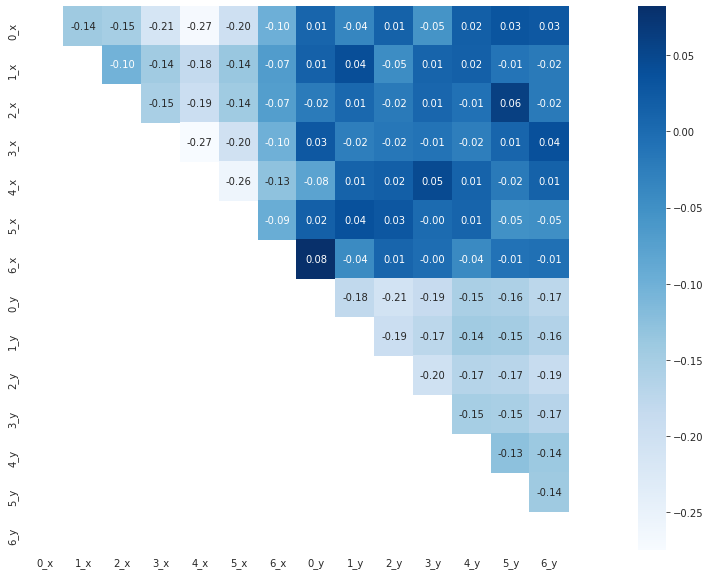

In [ ]:
corr = h.corr(method='spearman')
mask = np.tril(np.ones_like(corr, dtype=np.bool))
ax = plt.figure(figsize=(25,10))
ax = sns.heatmap(h.corr(method='spearman'), annot=True, fmt=".2f", mask = mask, square = True, cmap="Blues")

In [ ]:
a = pd.DataFrame(labels)
b= pd.DataFrame(y_pred)
c= pd.DataFrame()
c['labels'] = a[0].copy()
c['preds'] = b[0].copy()

In [ ]:
c.head()

,labels,preds
0,4,2
1,4,2
2,3,1
3,3,6
4,4,1


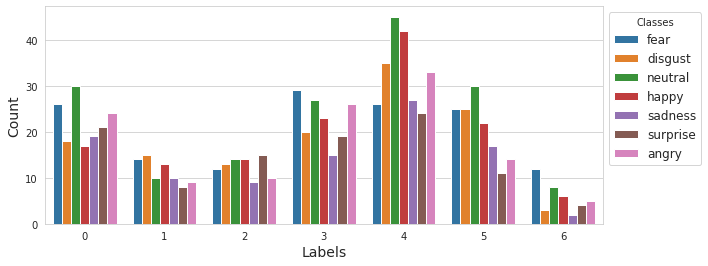

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(x='labels', hue="preds", data=c)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Classes', bbox_to_anchor = (1,1), labels=list(emotion_enc.keys()), fontsize='large')
plt.show()

### Plot clusters of emotions

- label 0 - class 5
- label 1 - class 2
- label 2 - class 1
- label 3 - class 3
- label 4 - class 6
- label 5 - class 0
- label 6 - class 4


In [ ]:
emotion_enc

{'angry': 6,
 'disgust': 1,
 'fear': 0,
 'happy': 3,
 'neutral': 2,
 'sadness': 4,
 'surprise': 5}

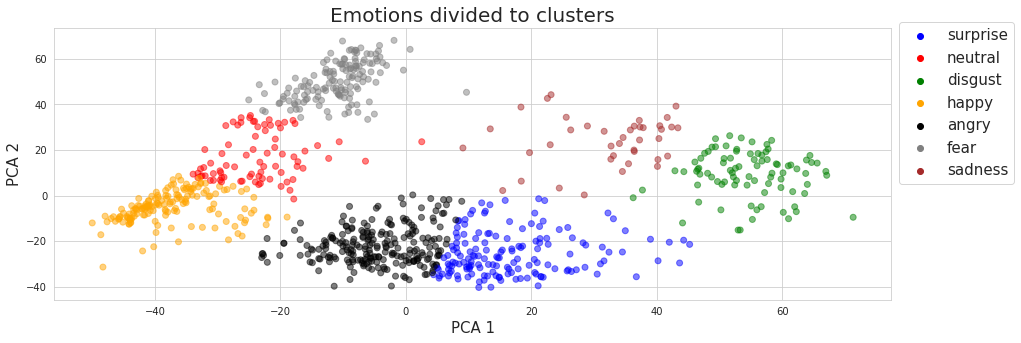

In [ ]:
colors = {0:'blue', 1:'red', 2:'green', 3:'orange', 4:'black', 5:'grey', 6:'brown'}
lab = ['surprise', 'neutral', 'disgust', 'happy', 'angry', 'fear', 'sadness']


fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c = pd.Series(labels).map(colors), alpha=0.5)
for i in range(7):
    plt.scatter(None, None, color=colors[i], label=lab[i])

plt.title('Emotions divided to clusters', fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor= [1, 1.05])
plt.xlabel('PCA 1', fontsize=15)
plt.ylabel('PCA 2', fontsize=15)
plt.show()

# Check on training data

In [ ]:
mydf = df_combined

In [ ]:
y = mydf['emotion3'].copy()

In [ ]:
y = y.reset_index(drop = True)
#new_x = new_x.reset_index(drop = True)

In [ ]:
X = []
for i in tqdm(mydf['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
import math

X_new = []
y_new = []
count = 0 
length_chosen = 120378
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

(4717,) (4717,)


In [ ]:
X

array([array([0.00060798, 0.00060798, 0.00060798, ..., 0.00060798, 0.00060798,
       0.00060798], dtype=float32),
       array([0.00038673, 0.00038673, 0.00038673, ..., 0.00038673, 0.00038673,
       0.00038673], dtype=float32),
       array([0.00079125, 0.00079125, 0.00079125, ..., 0.00079125, 0.00079125,
       0.00079125], dtype=float32),
       ...,
       array([0.00521335, 0.00603615, 0.00534158, ..., 0.00653263, 0.00611953,
       0.0058484 ], dtype=float32),
       array([0.00371752, 0.00427904, 0.00377774, ..., 0.00122611, 0.00114972,
       0.00111981], dtype=float32),
       array([0.00153902, 0.00153902, 0.00153902, ..., 0.00153902, 0.00153902,
       0.00153902], dtype=float32)], dtype=object)

In [ ]:
mfccs = []
counter = 0 
for i in tqdm(X):    
  samples_weiner = scipy.signal.wiener(i)   
  mfcc = librosa.feature.mfcc(y=samples_weiner, sr=44000, n_mfcc=40)
  mfcc = mfcc.T
  mfccs.append(mfcc)                                                        


In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

(4717, 236, 40)

In [ ]:
y = np.where(y=='positive', 'happy', y)
y = np.where(y=='negative', 'disgust', y)

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [ ]:
model_loaded = tf.keras.models.load_model('my_model_binary_scaled_pn_CHANGE_ORDER')

In [ ]:
y = pd.Series(y).map(emotion_enc)

In [ ]:
mfccs = scaler.transform(mfccs.reshape(-1, mfccs.shape[-1])).reshape(mfccs.shape)

In [ ]:
from sklearn.metrics import classification_report
predictions = model_loaded.predict(mfccs)
pred = [1 * (x[0]>=0.5) for x in predictions] #0.5 o 0.52? 
print(classification_report(y, pred))
#params = report_res_and_plot_matrix(y_val, y_pred, target)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2112
           1       1.00      1.00      1.00      2605

    accuracy                           1.00      4717
   macro avg       1.00      1.00      1.00      4717
weighted avg       1.00      1.00      1.00      4717



# Check on CREMA-D dataset

## Dataset download
**ATTENTION: RUN THE FOLLOWING CELLS ONLY THE FIRST TIME - SKIP THIS PART BECAUSE DATASETS ARE ALREADY IN GDRIVE**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"helemanc","key":"70a6e382dab75fbfda6cb749a53b3c17"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ejlok1/cremad

 99% 447M/451M [00:08<00:00, 51.0MB/s]
100% 451M/451M [00:08<00:00, 53.5MB/s]


In [ ]:
!unzip -q cremad.zip -d creamd

## Dataset extraction

In [26]:
Crema = "creamd/AudioWAV/"

In [27]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')

    # storing file paths
    file_path.append(Crema + file)
    if part[2] == 'SAD':
        file_emotion.append('sadness')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['labels'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df['source'] = 'CREAM'
Crema_df.head()

,labels,path,source
0,happy,creamd/AudioWAV/1079_WSI_HAP_XX.wav,CREAM
1,disgust,creamd/AudioWAV/1079_WSI_DIS_XX.wav,CREAM
2,happy,creamd/AudioWAV/1079_TSI_HAP_XX.wav,CREAM
3,angry,creamd/AudioWAV/1080_DFA_ANG_XX.wav,CREAM
4,neutral,creamd/AudioWAV/1079_WSI_NEU_XX.wav,CREAM


In [28]:
Crema_df.shape

(7442, 3)

In [29]:
Crema_df['labels'].unique()

array(['happy', 'disgust', 'angry', 'neutral', 'sadness', 'fear'],
      dtype=object)

In [30]:
crema_angry = Crema_df[Crema_df.labels == 'angry']
crema_disgust = Crema_df[Crema_df.labels == 'disgust']
crema_fear = Crema_df[Crema_df.labels == 'fear']
crema_happy = Crema_df[Crema_df.labels == 'happy']
crema_neutral = Crema_df[Crema_df.labels == 'neutral']
crema_sadness = Crema_df[Crema_df.labels == 'sadness']

In [31]:
crema_neutral

,labels,path,source
4,neutral,creamd/AudioWAV/1079_WSI_NEU_XX.wav,CREAM
5,neutral,creamd/AudioWAV/1080_DFA_NEU_XX.wav,CREAM
15,neutral,creamd/AudioWAV/1079_TIE_NEU_XX.wav,CREAM
17,neutral,creamd/AudioWAV/1079_TSI_NEU_XX.wav,CREAM
22,neutral,creamd/AudioWAV/1080_IEO_NEU_XX.wav,CREAM
...,...,...,...
7422,neutral,creamd/AudioWAV/1006_DFA_NEU_XX.wav,CREAM
7423,neutral,creamd/AudioWAV/1006_IEO_NEU_XX.wav,CREAM
7428,neutral,creamd/AudioWAV/1006_IOM_NEU_XX.wav,CREAM
7439,neutral,creamd/AudioWAV/1006_ITH_NEU_XX.wav,CREAM


### Angry

In [32]:
X = []
for i in tqdm(crema_angry['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

KeyboardInterrupt: ignored

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
y = crema_angry.labels

In [ ]:
y = y.reset_index(drop=True)

In [ ]:
import math
length_chosen = 120378

X_new = []
y_new = []
count = 0 
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

In [ ]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [ ]:
y = pd.Series(y).map(emotion_enc)

In [ ]:
with open('scaler.pickle', 'rb') as f:
  scaler = pickle.load(f)

In [ ]:
 mfccs = scaler.transform(mfccs.reshape(-1, mfccs.shape[-1])).reshape(mfccs.shape)

In [ ]:
model_loaded = tf.keras.models.load_model('my_model_binary_scaled_pn_CHANGE_ORDER')

In [ ]:
predictions = model_loaded.predict(mfccs)
pred = [1 * (x[0]>=0.50) for x in predictions]

In [ ]:
count_misclassified = 0 
for i in range(len(y)): 
  if y[i] != pred[i]: 
    count_misclassified +=1
count_misclassified

In [ ]:
print("Percentage of misclassified files: {} %".format((count_misclassified/len(y)*100)))

### Disgust

In [ ]:
X = []
for i in tqdm(crema_disgust['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
y = crema_disgust.labels

In [ ]:
y = y.reset_index(drop=True)

In [ ]:
import math
length_chosen = 120378

X_new = []
y_new = []
count = 0 
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

In [ ]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [ ]:
y = pd.Series(y).map(emotion_enc)

In [ ]:
with open('scaler.pickle', 'rb') as f:
  scaler = pickle.load(f)

In [ ]:
 mfccs = scaler.transform(mfccs.reshape(-1, mfccs.shape[-1])).reshape(mfccs.shape)

In [ ]:
model_loaded = tf.keras.models.load_model('my_model_binary_scaled_pn_CHANGE_ORDER')

In [ ]:
predictions = model_loaded.predict(mfccs)
pred = [1 * (x[0]>=0.50) for x in predictions]

In [ ]:
count_misclassified = 0 
for i in range(len(y)): 
  if y[i] != pred[i]: 
    count_misclassified +=1
count_misclassified

In [ ]:
print("Percentage of misclassified files: {} %".format((count_misclassified/len(y)*100)))

### Fear

In [ ]:
X = []
for i in tqdm(crema_fear['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
y = crema_fear.labels

In [ ]:
y = y.reset_index(drop=True)

In [ ]:
import math
length_chosen = 120378

X_new = []
y_new = []
count = 0 
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

In [ ]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [ ]:
y = pd.Series(y).map(emotion_enc)

In [ ]:
with open('scaler.pickle', 'rb') as f:
  scaler = pickle.load(f)

In [ ]:
 mfccs = scaler.transform(mfccs.reshape(-1, mfccs.shape[-1])).reshape(mfccs.shape)

In [ ]:
model_loaded = tf.keras.models.load_model('my_model_binary_scaled_pn_CHANGE_ORDER')

In [ ]:
predictions = model_loaded.predict(mfccs)
pred = [1 * (x[0]>=0.50) for x in predictions]

In [ ]:
count_misclassified = 0 
for i in range(len(y)): 
  if y[i] != pred[i]: 
    count_misclassified +=1
count_misclassified

In [ ]:
print("Percentage of misclassified files: {} %".format((count_misclassified/len(y)*100)))

### Happy

In [ ]:
X = []
for i in tqdm(crema_happy['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
y = crema_happy.labels

In [ ]:
y = y.reset_index(drop=True)

In [ ]:
import math
length_chosen = 120378

X_new = []
y_new = []
count = 0 
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

In [ ]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [ ]:
y = pd.Series(y).map(emotion_enc)

In [ ]:
with open('scaler.pickle', 'rb') as f:
  scaler = pickle.load(f)

In [ ]:
 mfccs = scaler.transform(mfccs.reshape(-1, mfccs.shape[-1])).reshape(mfccs.shape)

In [ ]:
model_loaded = tf.keras.models.load_model('my_model_binary_scaled_pn_CHANGE_ORDER')

In [ ]:
predictions = model_loaded.predict(mfccs)
pred = [1 * (x[0]>=0.50) for x in predictions]

In [ ]:
count_misclassified = 0 
for i in range(len(y)): 
  if y[i] != pred[i]: 
    count_misclassified +=1
count_misclassified

In [ ]:
print("Percentage of misclassified files: {} %".format((count_misclassified/len(y)*100)))

### Neutral

In [ ]:
X = []
for i in tqdm(crema_neutral['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
y = crema_neutral.labels

In [ ]:
y = y.reset_index(drop=True)

In [ ]:
import math
length_chosen = 120378

X_new = []
y_new = []
count = 0 
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

In [ ]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [ ]:
y = pd.Series(y).map(emotion_enc)

In [ ]:
with open('scaler.pickle', 'rb') as f:
  scaler = pickle.load(f)

In [ ]:
 mfccs = scaler.transform(mfccs.reshape(-1, mfccs.shape[-1])).reshape(mfccs.shape)

In [ ]:
model_loaded = tf.keras.models.load_model('my_model_binary_scaled_pn_CHANGE_ORDER')

In [ ]:
predictions = model_loaded.predict(mfccs)
pred = [1 * (x[0]>=0.50) for x in predictions]

In [ ]:
count_misclassified = 0 
for i in range(len(y)): 
  if y[i] != pred[i]: 
    count_misclassified +=1
count_misclassified

In [ ]:
print("Percentage of misclassified files: {} %".format((count_misclassified/len(y)*100)))

### Sadness

In [ ]:
X = []
for i in tqdm(crema_sadness['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
y = crema_sadness.labels

In [ ]:
y = y.reset_index(drop=True)

In [ ]:
import math
length_chosen = 120378

X_new = []
y_new = []
count = 0 
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

In [ ]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [ ]:
y = pd.Series(y).map(emotion_enc)

In [ ]:
with open('scaler.pickle', 'rb') as f:
  scaler = pickle.load(f)

In [ ]:
 mfccs = scaler.transform(mfccs.reshape(-1, mfccs.shape[-1])).reshape(mfccs.shape)

In [ ]:
model_loaded = tf.keras.models.load_model('my_model_binary_scaled_pn_CHANGE_ORDER')

In [ ]:
predictions = model_loaded.predict(mfccs)

In [ ]:
pred = [1 * (x[0]>=0.50) for x in predictions]

In [ ]:
count_misclassified = 0 
for i in range(len(y)): 
  if y[i] != pred[i]: 
    count_misclassified +=1
count_misclassified

In [ ]:
print("Percentage of misclassified files: {} %".format((count_misclassified/len(y)*100)))

### All classes

In [ ]:
X = []
for i in tqdm(Crema_df['path']): 
    X.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [ ]:
y = Crema_df.labels

In [ ]:
y = y.reset_index(drop=True)

In [ ]:
import math
length_chosen = 120378

X_new = []
y_new = []
count = 0 
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
        y_new.append(y[count])
    count+=1
            

In [ ]:
X = np.array(X_new)
y = np.array(y_new)
print(X.shape, y.shape)

In [ ]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)


In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [ ]:
y = pd.Series(y).map(emotion_enc)

In [ ]:
with open('scaler.pickle', 'rb') as f:
  scaler = pickle.load(f)

In [ ]:
 mfccs = scaler.transform(mfccs.reshape(-1, mfccs.shape[-1])).reshape(mfccs.shape)

In [ ]:
model_loaded = tf.keras.models.load_model('my_model_binary_scaled_pn_CHANGE_ORDER')

In [ ]:
predictions = model_loaded.predict(mfccs)
pred = [1 * (x[0]>=0.50) for x in predictions]

In [ ]:
count_misclassified = 0 
for i in range(len(y)): 
  if y[i] != pred[i]: 
    count_misclassified +=1
count_misclassified

In [ ]:
print("Percentage of misclassified files: {} %".format((count_misclassified/len(y)*100)))

In [ ]:
from sklearn.metrics import classification_report
predictions = model_loaded.predict(mfccs)
pred = [1 * (x[0]>=0.50) for x in predictions] 
print(classification_report(y, pred))

# Check random samples from dataset

In [ ]:
import os
path = "/content" # /content is pretty much the root. you can choose other path in your colab workspace
os.chdir(path)

In [ ]:
x,sr = librosa.load('OAF_bar_sad.wav',
             res_type='kaiser_fast', sr=44000)

In [ ]:
x.shape, length_chosen

((110077,), 120378)

In [ ]:
if x.shape[0] > length_chosen:
        new = x[:length_chosen]
elif x.shape[0] < length_chosen:
        new = np.pad(x,math.ceil((length_chosen-x.shape[0])/2), mode='median')
else:
        new = x



In [ ]:
mfcc = librosa.feature.mfcc(y=new, sr=44000, n_mfcc=40)
mfcc = mfcc.T
mfcc.shape

(236, 40)

In [ ]:
mfcc = mfcc.reshape(1,236,40)
mfcc.shape

(1, 236, 40)

In [ ]:
predictions = model_loaded.predict(mfcc)
pred = [1 * (x[0]>=0.52) for x in predictions]

In [ ]:
predictions

array([[0.5158022]], dtype=float32)

In [ ]:
pred

[0]

In [ ]:
emotion_enc

{'angry': 1,
 'disgust': 1,
 'fear': 1,
 'happy': 0,
 'neutral': 0,
 'sadness': 1,
 'surprise': 0}

# Validation on EMO-DB

In [ ]:
EMODB = "emodb/wav/"

emodb_directory_list = os.listdir(EMODB)
emotion = []
path = []

for root, dirs, files in os.walk(EMODB):
  for name in files:
      if name[0:2] in '0310111215':  # MALE
          if name[5] == 'W':  # Ärger (Wut) -> Angry
              emotion.append('angry')
          elif name[5] == 'E':  # Ekel -> Disgusted
              emotion.append('disgust')
          elif name[5] == 'A':  # Angst -> Angry
              emotion.append('angry')
          elif name[5] == 'F':  # Freude -> Happiness
              emotion.append('happy')
          elif name[5] == 'T':  # Trauer -> Sadness
              emotion.append('sadness')
          else:
              emotion.append('unknown')
      else:
          if name[5] == 'W':  # Ärger (Wut) -> Angry
              emotion.append('angry')
          elif name[5] == 'E':  # Ekel -> Disgusted
              emotion.append('disgust')
          elif name[5] == 'A':  # Angst -> Angry
              emotion.append('angry')
          elif name[5] == 'F':  # Freude -> Happiness
              emotion.append('happy')
          elif name[5] == 'T':  # Trauer -> Sadness
              emotion.append('sadness')
          else:
              emotion.append('unknown')

      path.append(os.path.join(EMODB, name))

emodb_df = pd.DataFrame(emotion, columns=['labels'])
emodb_df['source'] = 'EMODB'
emodb_df = pd.concat([emodb_df, pd.DataFrame(path, columns=['path'])], axis=1)



In [ ]:
emodb_df.head()

,labels,source,path
0,unknown,EMODB,emodb/wav/03a02Nc.wav
1,unknown,EMODB,emodb/wav/03a01Nc.wav
2,happy,EMODB,emodb/wav/03a02Fc.wav
3,sadness,EMODB,emodb/wav/03a02Ta.wav
4,happy,EMODB,emodb/wav/03a01Fa.wav


In [ ]:
# remove 'unknown'rows
emodb_df.drop(index=emodb_df[emodb_df['labels'] == 'unknown'].index, inplace=True)

In [ ]:
emodb_df.head()

,labels,source,path
2,happy,EMODB,emodb/wav/03a02Fc.wav
3,sadness,EMODB,emodb/wav/03a02Ta.wav
4,happy,EMODB,emodb/wav/03a01Fa.wav
5,angry,EMODB,emodb/wav/03a02Wb.wav
6,angry,EMODB,emodb/wav/03a01Wa.wav


In [ ]:
y_emodb = emodb_df['labels'].copy()

In [ ]:
y_emodb = y_emodb.reset_index(drop=True)

In [ ]:
y_emodb

0        happy
1      sadness
2        happy
3        angry
4        angry
        ...   
745      angry
746      angry
747      angry
748      happy
749      angry
Name: labels, Length: 750, dtype: object

In [ ]:
y_emodb.shape

(750,)

In [ ]:
X_emodb = []
for i in tqdm(emodb_df['path']): 
    X_emodb.append(librosa.load(i, res_type='kaiser_fast', sr=44000))

In [ ]:
new_x_emodb = []
for ind,i in enumerate(X_emodb):
    new_x_emodb.append(i[0])

In [ ]:
import math
length_chosen = 120378

X_new_emodb = []
y_new_emodb = []
for ind,i in enumerate(new_x_emodb):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new_emodb.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new_emodb.append(new)
        else:
            X_new_emodb.append(i)
            
        y_new_emodb.append(y_emodb[ind])
            

In [ ]:
X_emodb = np.array(X_new_emodb)
y_emodb = np.array(y_new_emodb)
print(X_emodb.shape, y_emodb.shape)

(746,) (746,)


In [ ]:
y_emodb

array(['happy', 'sadness', 'happy', 'angry', 'angry', 'disgust',
       'disgust', 'angry', 'disgust', 'sadness', 'angry', 'angry',
       'angry', 'angry', 'angry', 'angry', 'happy', 'angry', 'disgust',
       'angry', 'disgust', 'angry', 'happy', 'happy', 'angry', 'angry',
       'happy', 'angry', 'angry', 'angry', 'happy', 'happy', 'angry',
       'sadness', 'angry', 'angry', 'angry', 'angry', 'angry', 'sadness',
       'happy', 'sadness', 'angry', 'happy', 'disgust', 'happy', 'angry',
       'happy', 'happy', 'angry', 'angry', 'angry', 'angry', 'sadness',
       'angry', 'angry', 'angry', 'sadness', 'sadness', 'happy', 'angry',
       'angry', 'disgust', 'disgust', 'happy', 'happy', 'sadness',
       'happy', 'sadness', 'angry', 'happy', 'angry', 'disgust',
       'sadness', 'happy', 'sadness', 'angry', 'angry', 'happy', 'angry',
       'angry', 'angry', 'angry', 'disgust', 'angry', 'sadness',
       'sadness', 'angry', 'angry', 'sadness', 'happy', 'angry', 'angry',
       'sadness

In [ ]:
mfccs_emodb = []
for i in tqdm(X_emodb):
    mfcc_emodb = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc_emodb = mfcc_emodb.T
    mfccs_emodb.append(mfcc_emodb)


In [ ]:
mfccs_emodb = np.array(mfccs_emodb)
mfccs_emodb.shape

(746, 236, 40)

In [ ]:
with open('scaler.pickle', 'rb') as f:
  scaler = pickle.load(f)

In [ ]:
mfccs_emodb = scaler.transform(mfccs_emodb.reshape(-1, mfccs_emodb.shape[-1])).reshape(mfccs_emodb.shape)

In [ ]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [ ]:
y_emodb = pd.Series(y_emodb).map(emotion_enc)

In [ ]:
np.unique(y_emodb)

array([0, 1])

In [ ]:
from sklearn.metrics import classification_report
predictions = model_loaded.predict(mfccs_emodb)
pred = [1 * (x[0]>=0.52) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_emodb, pred))

              precision    recall  f1-score   support

           0       0.26      0.29      0.27       142
           1       0.83      0.81      0.82       604

    accuracy                           0.71       746
   macro avg       0.54      0.55      0.55       746
weighted avg       0.72      0.71      0.71       746



# Check on 